<a href="https://colab.research.google.com/github/soneyahossain/deep_learning_project/blob/master/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!unzip data-1.zip


Archive:  data-1.zip
replace data-1/oldCabell2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd


class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_names = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_names = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        print(image_names[0])
        print(label_ids[0])
        print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_names[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_, image_name,class_name 
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

   
train_dataset1 = UVaBuildinglabel('data-1', 'data-1/label.csv')
#val_dataset1 = CocoMultilabel('coco_256x256/val', 'annotations/instances_val2014.json')


torch.Size([3, 320, 320])
4


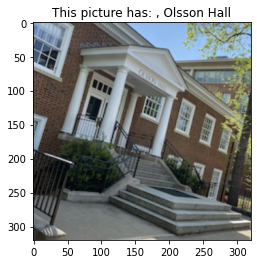

In [81]:
import matplotlib.pyplot as plt
my_image, my_label,_,class_name  = train_dataset1.__getitem__(279)

print(my_image.shape)
print(my_label)

# Show the image and its label.
plt.figure()
label = class_name
plt.title("This picture has: " + ", "+label)
# Undo normalization of the pixel values.

# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image.transpose(0,2).transpose(0,1));
#plt.grid(False); plt.axis('off');